In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group01\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group01\.qcodes\logs\240607-16336-qcodes.log


In [2]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.IQ_modulation('EXT')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.32s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.16s
Connected to: KORAD KD3005P V6.7 SN 48562561 (serial:None, firmware:None) in 0.05s


0

## Review Exercises

### Q1. Review the figures below. For each figure, in words, explain whether you expect the output signal on the lock-in amplifier to be low (i.e. background noise), or high. 

#### Case 1.
<img src="attachment:4379ccc0-af86-499a-a807-5808aed39551.png" width="600"/>

#### Case 2.
<img src="attachment:bc02b075-6003-4811-b657-fcd1e0bdcf67.png" width="600"/>

### Q2.  Review the figure below. In words, explain whether you expect the output signal on the lock-in namplifier to be low (i.e. background noise), or high, under each of the following conditions: a) The microwave output is off, b) The microwave output is on at 1 GHz, c) The microwave output is on at 2.87 GHz.

<img src="attachment:a5caa740-8aaf-4acd-bfac-7f35595c6b4e.png" width="600"/>

## Optically Detected Magnetic Resonance Magnetometry

In the previous lab, we had performed an experiment to measure the optically detected magnetic resonance at zero magnetic field. In this task, we shall apply a DC magnetic field to the diamond sample and observe what happens to the resonance peaks.

Set the current to 0.5A and observe how this spectrum differs from one with no magnetic field applied.

In [3]:
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(0.5) #Set to 0.5A

#Use this to make a parameter out of anything!
MW= qc.ManualParameter('Frequency', unit='Hz')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "ODMR Magnetometry.db")
experiment = load_or_create_experiment(
    experiment_name='ODMR Coil Constant',
    sample_name=""
)

meas = Measurement(exp=experiment, name='ODMR Coil Constant')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent one

In [1]:
laser_f = 100e3                                   #Laser modulation frequency.
laser_D = 0.3    

T_mw_on = laser_D/laser_f  

In [2]:
print(T_mw_on)

3e-06


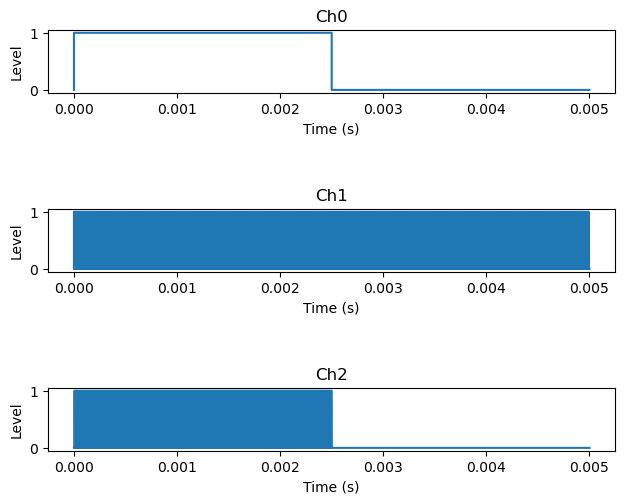

In [4]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                     #Reference duty cycle.
T_ref_on = ref_D/ref_f                 #Reference time on.
T_ref_off = (1 - ref_D)/ref_f  

#TODO: Specifiy these constants.
laser_f = 100e3                                   #Laser modulation frequency.
laser_D = 0.3                                        #Laser modulation duty cycle.
T_laser_on = laser_D/laser_f                #Laser on time. 
T_laser_off = (1 - laser_D)/laser_f         #Laser off time.
N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
mw_D = laser_D                               #Microwave modulation duty cycle.
T_mw_on = laser_D/laser_f                      #Microwave time on.
T_mw_off = (1 - laser_D)/laser_f                #Microwave time off.
T_mw_on = (1 - laser_D)/laser_f                       #Microwave time on.
T_mw_off =  laser_D/laser_f
N_mw_pulses = round(laser_f/(ref_f*2))             #Number of microwave pulses that can fit in the reference period.

tau = #1e-6

def ODMR_PP():
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
        #TODO: Enter the laser pulse sequence.
        
    )                                     #Define the new pulse sequence for channel 0.
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)]   
        #TODO: Enter the laser pulse sequence.
        
    )                                     #Define the new pulse sequence for channel 1.
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        [[pulse(level=0, duration=T_mw_off+tau), pulse(level=1, duration= T_mw_on-2*tau),  pulse(level=0, duration=tau)] for i in range(0, N_mw_pulses)] +
        [pulse(level=0, duration=float(1/(2*ref_f)))]
        #TODO: Enter the laser pulse sequence.
    )                                     #Define the new pulse sequence for channel 2.

ODMR_PP()
pulse_blaster.plot_channel_buffer() 
pulse_blaster.flush_channel_buffer()  #This function plots the newly defined pulse sequence.

In [5]:
pulse_blaster.stop()
microwave_src.output('OFF')
#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant(1)#Your time constant here)
lock_in_amp.sensitivity(100e-12)

#Write period is the amount of time between start to finish of the experiment.
f_start = 2.6e9#2.6e9 #start time (in seconds)
num_steps = 100 #Number of steps
f_end = 2.9e9#2.99e9 #end time. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)
freq_step = (f_end - f_start)/num_steps

In [6]:
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(0.5) #Set to 0.5A

In [ ]:
microwave_src.power(-10)#MW power here) #<= 15dBm
microwave_src.output('ON')
freqs = np.linspace(f_start, f_end, num_steps)
ODMR_PP()
pulse_blaster.flush_channel_buffer()
with meas.run() as datasaver:
    for i in range(freqs.size): 
        #Reinitialize the pulse sequence with the new tau.
        #This is a good approach to initializing a new pulse sequence in a loop.
        microwave_src.frequency(freqs[i])
        print(i)

        pulse_blaster.flush_channel_buffer()
        #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
        if i == 0:
            sleep(10*lock_in_amp.time_constant())
        else:
            sleep(2*lock_in_amp.time_constant())
        ###############################
        #Specify the data being saved below
        datasaver.add_result((MW, freqs[i]),
                             (LI_R, lock_in_amp.R()))
        ###############################
    
    ODMR_data = datasaver.dataset
pulse_blaster.stop()

ODMR = ODMR_data.to_pandas_dataframe()
plt.plot(ODMR["Frequency"], ODMR["Signal"])
plt.xlabel('Frequency(Hz)')
plt.ylabel('Signal(V)')
plt.title(f'ODMR({10}dBm)')
plt.show()

In [ ]:
# microwave_src.output('ON')
# ODMR_PP()
# pulse_blaster.flush_channel_buffer()
# with meas.run() as datasaver:
#     ##########################
#     #Your experiment code here
        
#     ##########################
#     ODMR_data = datasaver.dataset  # convenient to have for data access and plotting

# ODMR = ODMR_data.to_pandas_dataframe()
# plt.plot(ODMR["Frequency"], ODMR["Signal"])
# plt.xlabel('Frequency(Hz)')
# plt.ylabel('Signal(V)')
# plt.title('ODMR')
# plt.show()

## Coil Constant Determination
The coils of the electromagnet are driven by a DC power supply that can be programmed through Matlab. The magnetic field produced by the coils is proportional to the currentpassing through the wires, and so one can easily convert between current and magnetic fieldstrength using a scaling factor. This scaling factor is called the coil constant and usually given in units of Tesla per Ampere [T/A]. <br>
Write experimental code to sweep frequency and current applied to the magnet and make a contour graph of the resultant LIA signal.

In [7]:
#Use this to make a parameter out of anything!
MW= qc.ManualParameter('Frequency', unit='Hz')
Korad = qc.ManualParameter('Current', unit ='A')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "ODMR Current and Frequency Sweep.db")
experiment = load_or_create_experiment(
    experiment_name='ODMR Current and Frequency Sweep',
    sample_name=""
)

meas = Measurement(exp=experiment, name='ODMR Current and Frequency Sweep')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(Korad)  # register the second independent parameter
meas.register_parameter(LI_R) # now register the dependent one

In [8]:
pulse_blaster.stop()
#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant(3)#Your time constant here)
lock_in_amp.sensitivity(100e-12)#Your sensitivity here)
#Now we try it with more power.
microwave_src.power(-10)#Your power here)      #<= 15dBm
#microwave_src.frequency(#Microwave Frequency)
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(0)

#Write period is the amount of time between start to finish of the experiment.
f_start = 2.65e9 #start time (in seconds)
num_freq_steps = 200 #Number of steps
f_end = 3e9 #end time. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)
freq_step = (f_end - f_start)/num_freq_steps

cur_min = 0 #Minimum value of the current
cur_max = 0.8 #Maximum value of the current
num_steps = 25
cur_stepsize = (cur_min - cur_max)/num_steps #stepsize


In [9]:
freqs = np.linspace(f_start, f_end, num_freq_steps)
currs =np.linspace(cur_min, cur_max, num_steps) # np.array([0.4])
print(currs[-1])
result = []

0.8


In [ ]:
#Run the experiment
microwave_src.output('ON')
dc_supply.ch1.voltage_setpoint(12)
ODMR_PP()
pulse_blaster.flush_channel_buffer()
for j in range(17, currs.size):
    dc_supply.ch1.current_setpoint(currs[j])
    with meas.run() as datasaver:
        for i in range(freqs.size): 
            #Reinitialize the pulse sequence with the new tau.
            #This is a good approach to initializing a new pulse sequence in a loop.
            microwave_src.frequency(freqs[i])
            print(i)

            pulse_blaster.flush_channel_buffer()
            #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
            if i == 0:
                sleep(10*lock_in_amp.time_constant())
            else:
                sleep(2*lock_in_amp.time_constant())
            ###############################
            #Specify the data being saved below
            datasaver.add_result((MW, freqs[i]),
                                (LI_R, lock_in_amp.R()))
            ###############################
    
        Cur_Freq_Sweep_Data = datasaver.dataset  # convenient to have for data access and plotting
        result.append(Cur_Freq_Sweep_Data)
pulse_blaster.stop()

- (-10dbM) power
- Sweep current from 0 to 0.8 for 25 points
- Sweep frequency for 150 points from 2.67 to 3.0e9
- Should take 4.375 hours 

In [ ]:
# for r, c in zip(result, new_currs):
#     ODMR = r.to_pandas_dataframe()
#     ODMR.to_csv(f"./ODMR_data_new/ODMR_{c}A_test.csv")

In [14]:
# for r, c in zip(result, new_currs):
#     ODMR = r.to_pandas_dataframe()
#     ODMR.to_csv(f"./ODMR_data_new/ODMR_{c}A_test.csv")

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ])

In [15]:
print(type(currs))

<class 'numpy.ndarray'>


In [16]:
import pandas as pd
df = []
for i in range(currs.size):
    df.append(pd.read_csv(f"./ODMR_data_new/ODMR_{currs[i]}A_test.csv"))

In [17]:
print(df)

[     Unnamed: 0  Current     Frequency        Signal
0             0      NaN  2.650000e+09  4.796200e-13
1             1      NaN  2.651759e+09  6.821240e-13
2             2      NaN  2.653518e+09  6.963350e-13
3             3      NaN  2.655276e+09  7.567310e-13
4             4      NaN  2.657035e+09  7.531790e-13
..          ...      ...           ...           ...
195         195      NaN  2.992965e+09  6.714660e-13
196         196      NaN  2.994724e+09  6.537030e-13
197         197      NaN  2.996482e+09  6.998880e-13
198         198      NaN  2.998241e+09  6.075180e-13
199         199      NaN  3.000000e+09  6.359390e-13

[200 rows x 4 columns],      Unnamed: 0  Current     Frequency        Signal
0             0      NaN  2.650000e+09  5.258050e-13
1             1      NaN  2.651759e+09  5.790960e-13
2             2      NaN  2.653518e+09  5.187000e-13
3             3      NaN  2.655276e+09  7.176520e-13
4             4      NaN  2.657035e+09  6.572560e-13
..          ...     

In [65]:
def find_local_maxima(func_values, window_size=3, tolerance=0):
    maxima = []
    n = len(func_values)
    if n < window_size:
        return maxima  # Not enough elements to find local maxima

    for i in range(n):
        left = max(0, i - window_size // 2)
        right = min(n, i + window_size // 2 + 1)
        if func_values[i] >= max(func_values[left:right]) + tolerance:
            # maxima.append((i, func_values[i]))
            maxima.append((i))
    return maxima


In [62]:
indices = find_local_maxima(ODMR['Signal'], window_size=3) 
freq = ODMR['Frequency'].to_numpy()

signal = ODMR['Signal'].to_numpy()
peaks = [freq[i] for i in indices if signal[i] > 0.13e-11]

In [63]:
import matplotlib.pyplot as plt

def plot_vertical_lines(x_positions, ymin, ymax):
    for x in x_positions:
        plt.axvline(x=x, color='r', linestyle='--')  # Adjust color and linestyle as needed
    plt.ylim(ymin, ymax)  # Adjust y-axis limits as needed


In [70]:
def filter_close_elements(lst, epsilon):
    lst.sort()  # Sort the list in ascending order
    filtered_list = [lst[0]]  # Initialize the filtered list with the first element

    for i in range(1, len(lst)):
        # Check the difference between the current element and the last element in the filtered list
        if abs(lst[i] - filtered_list[-1]) >= epsilon:
            filtered_list.append(lst[i])

    return filtered_list


0


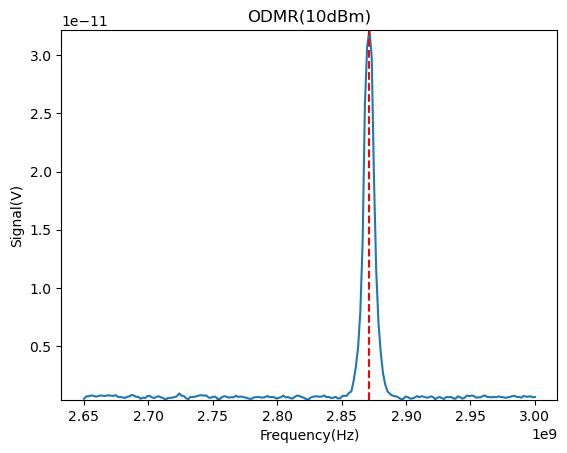

1


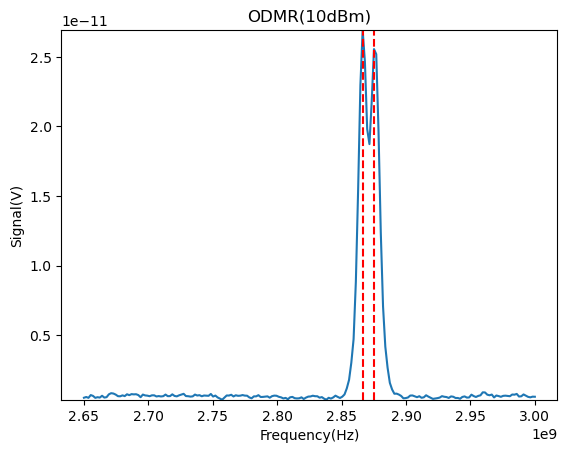

2


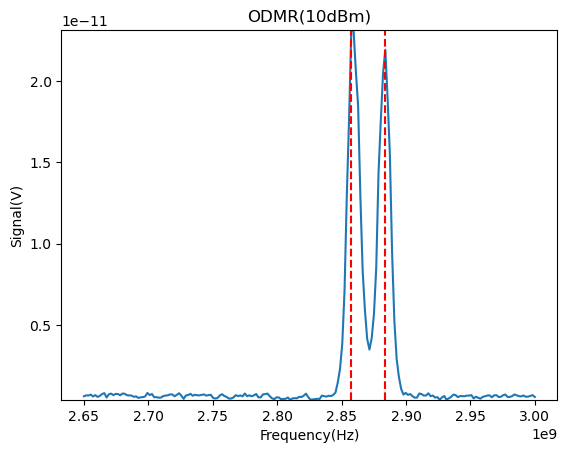

3


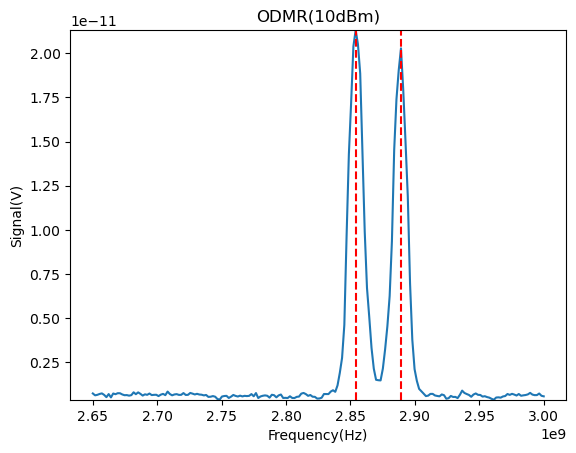

4


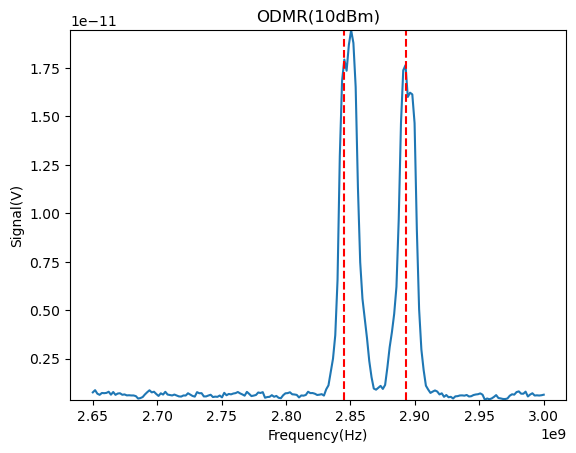

5


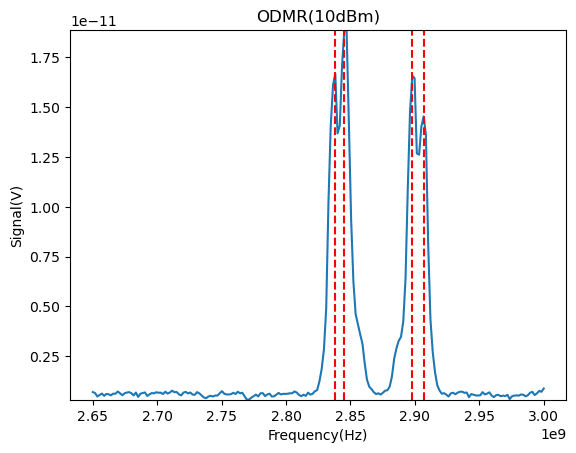

6


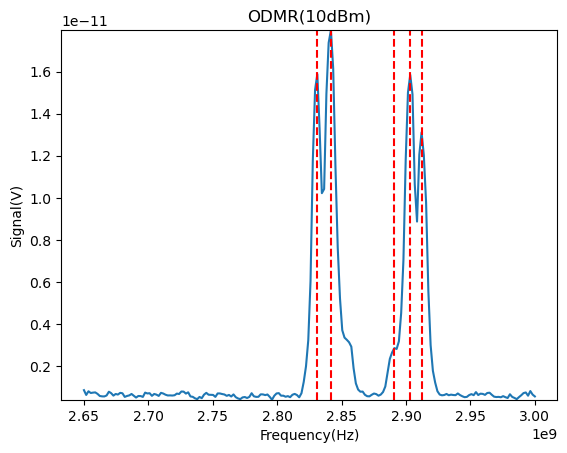

7


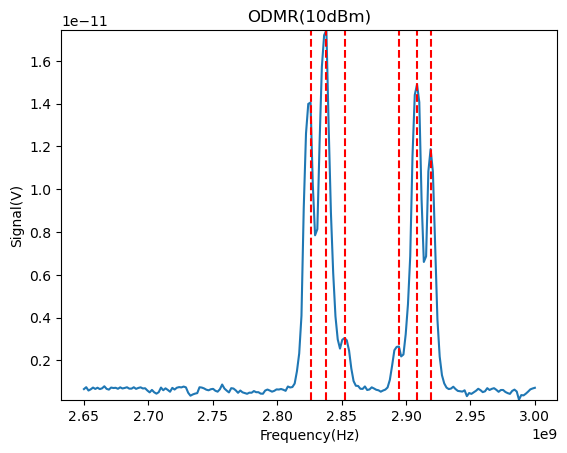

8


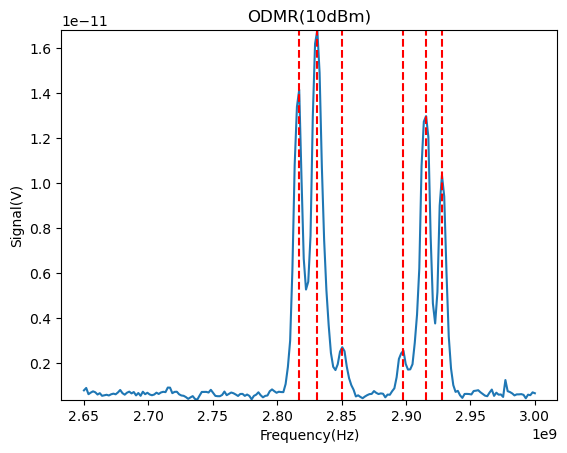

9


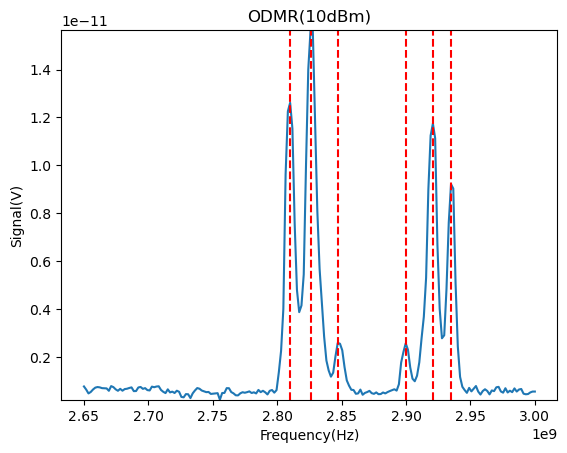

10


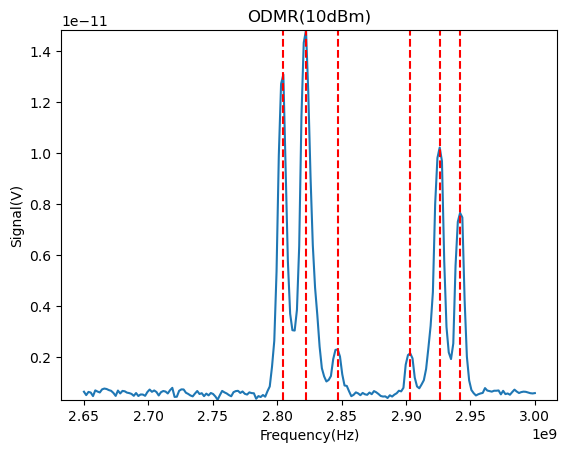

11


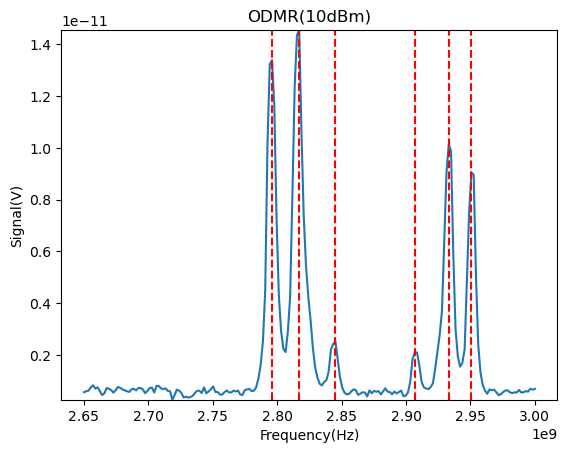

12


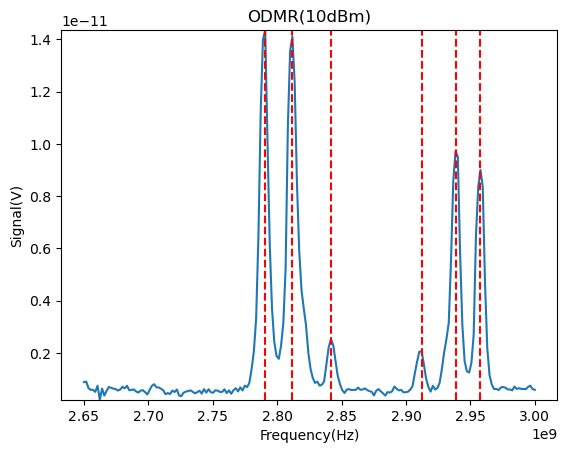

13


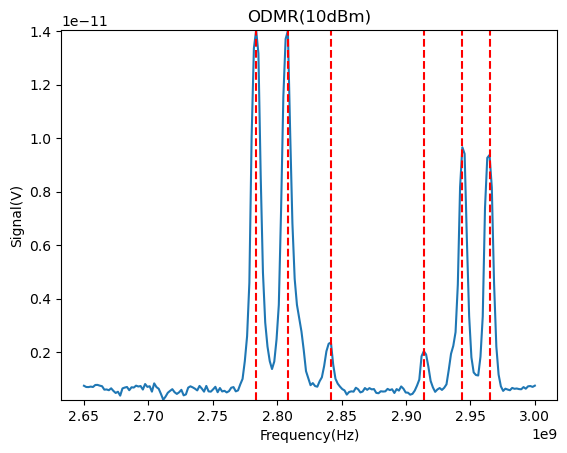

14


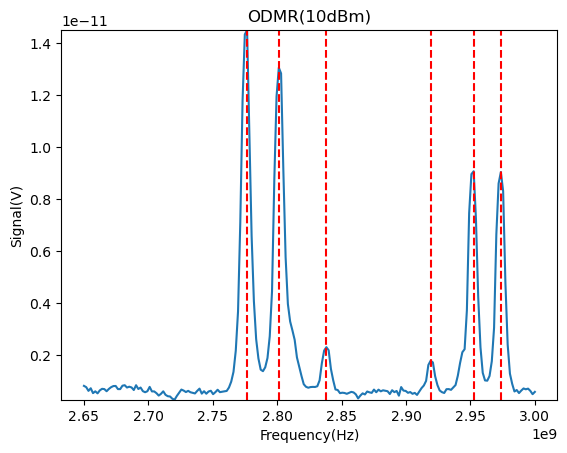

15


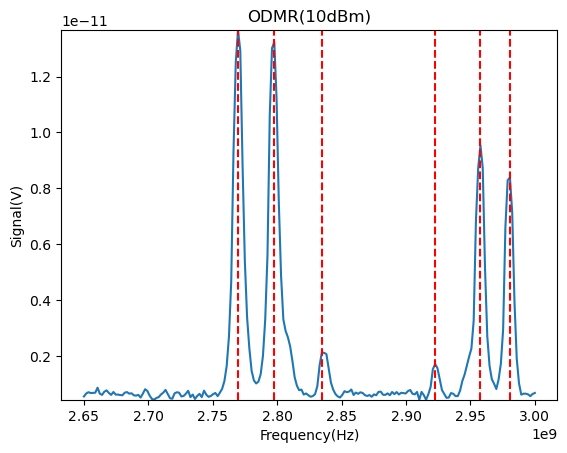

16


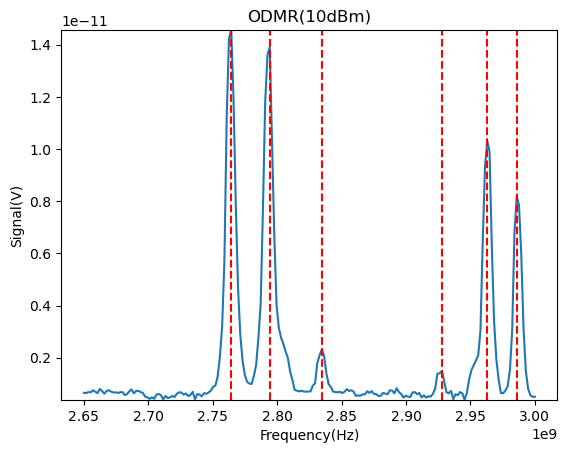

17


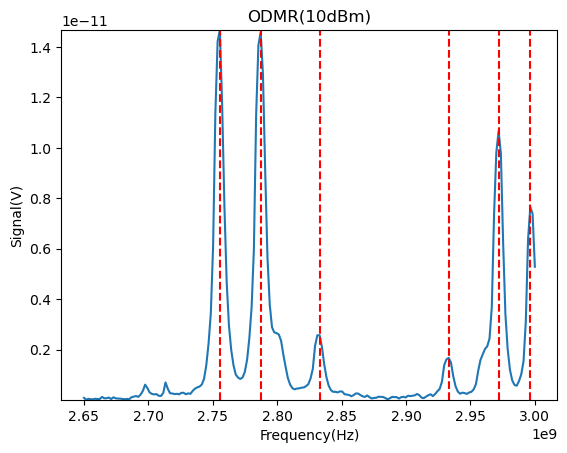

18


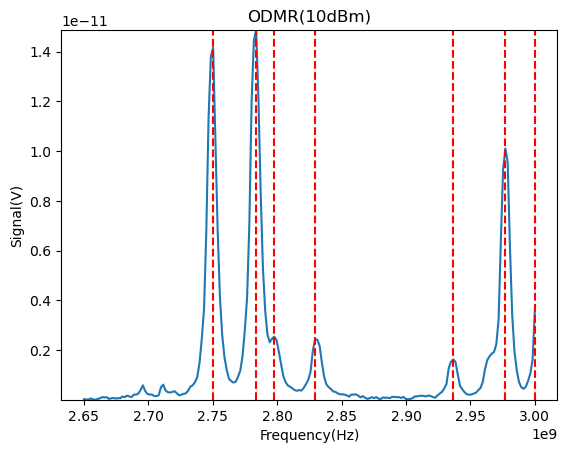

19


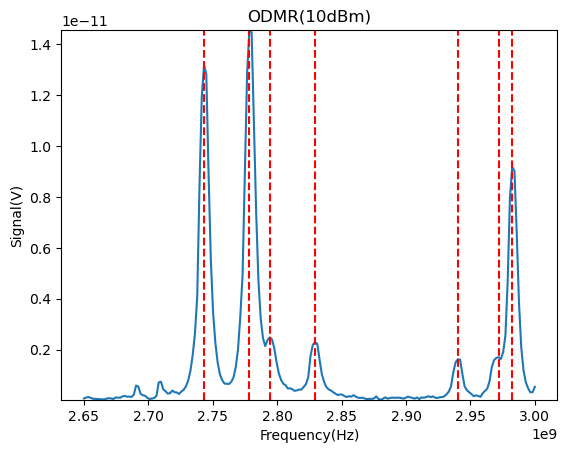

20


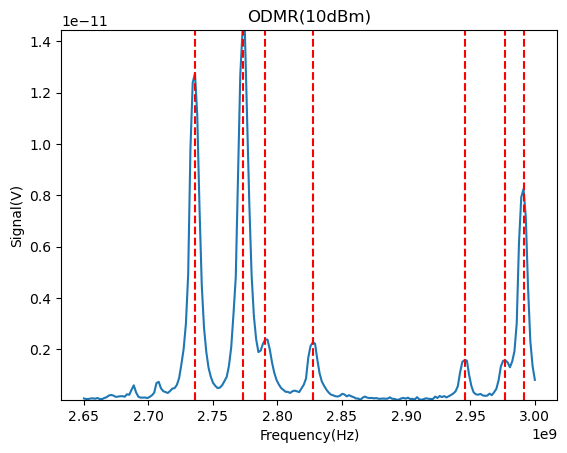

21


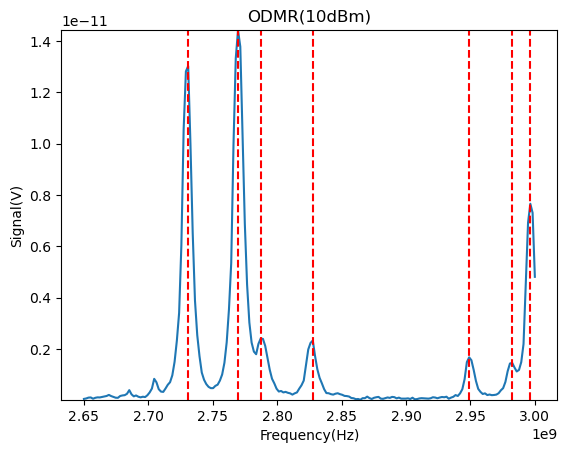

22


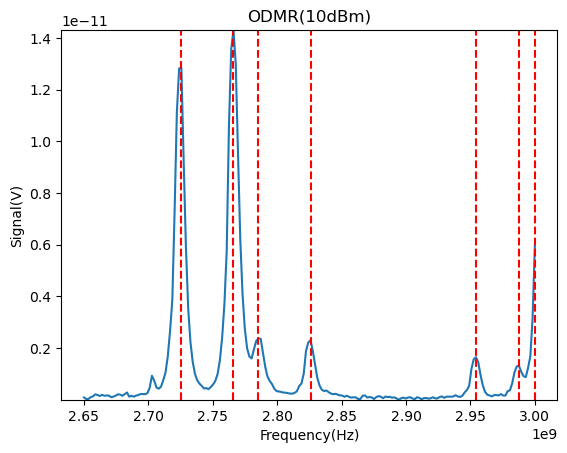

23


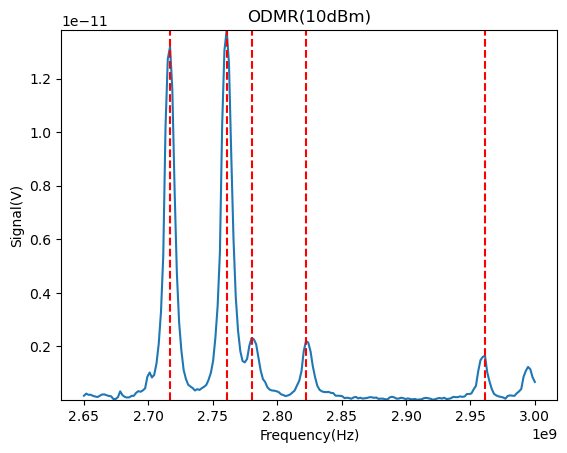

24


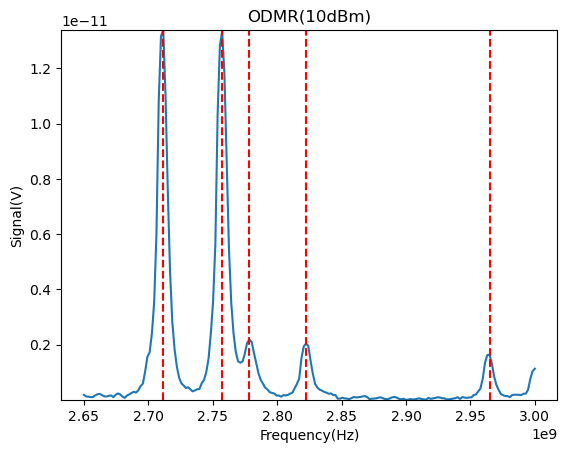

In [85]:
peak_coords = []
for i, ODMR in enumerate(df):
    print(i)
    freq = ODMR['Frequency'].to_numpy()
    signal = ODMR['Signal'].to_numpy()
    indices = find_local_maxima(ODMR['Signal'], window_size=3)# tolerance=0.01e-11) 
    peaks = [freq[i] for i in indices if signal[i] > 0.13e-11]
    peaks = filter_close_elements(peaks, 5276381.90955019)
    peak_coords = peak_coords + [(currs[i], p) for p in peaks]


    plt.plot(ODMR["Frequency"], ODMR["Signal"])
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Signal(V)')
    plot_vertical_lines(peaks, np.min(ODMR["Signal"]), np.max(ODMR["Signal"]))
    plt.title(f'ODMR({10}dBm)')
    plt.show()

### Q3. Carefully note the various salient features of the ODMR spectra. How many resonance peakscan be observed? How many do we expect to see? Do all the resonance peaks react to achange in coil current amplitude in the same way?

## Simulating ODMR using the NV Hamiltonian

As was pointed out in the first lab and is shown in Fig. 6, The NV center in diamond can be oriented in four unique directions with respect to the crystal axis. Each orientation of the NV center experiences a different effective magnetic field. Thus, the direction of the applied magnetic field may have a significant effect on the ODMR spectra we wish to observe. In this task, we would like to simulate the NV center’s Hamiltonian in order to figure out the orientation of the magnetic field produced by the coils with respect to the sample. 

Before we begine the simulation, we must define:

1. The spin gyromagnetic ratio ('g_e') and zero-field splitting ('D').
2. The spin-1 operators ('S').
3. The primitive vectors of a face-centre cubic lattice ('e').
4. The NV axis vectors ('NV_axis').

In [10]:
g_e = 28e9
D = 2.87e9

S = {'x': [], 'y': [], 'z': []}
S['x'] = np.array([[             0,    1/np.sqrt(2),              0],
                   [  1/np.sqrt(2),               0,   1/np.sqrt(2)],
                   [              0,   1/np.sqrt(2),              0]])

S['y'] = np.array([[              0, -1j/np.sqrt(2),              0],
                   [  1j/np.sqrt(2),              0, -1j/np.sqrt(2)],
                   [              0,  1j/np.sqrt(2),              0]])

S['z'] = np.array([[              1,              0,              0],
                   [              0,              0,              0],
                   [              0,              0,             -1]])

e = {'x': np.array([1, 0, 0]),
     'y': np.array([0, 1, 0]),
     'z': np.array([0, 0, 1])}

NV_axis = np.array([[ 1,  1,  1],
                    [-1, -1,  1],
                    [-1,  1, -1],
                    [ 1, -1, -1]])
NV_axis = [axis / np.linalg.norm(axis) for axis in NV_axis]
NV_comp = {key: [np.dot(axis, e[key]) for axis in NV_axis] for key in e}

For this task adjust the direction of the magnetic field vector ('u') and the coil constant ('coil_constant') (the scaling factor that allows you to convert from current to magnetic field) in the code until the ODMR spectra ‘map’ matches that of the experimental result. Starting values have been provided for you.

In [112]:
random_offset

array([0.64011104, 0.30144144, 0.81424192])

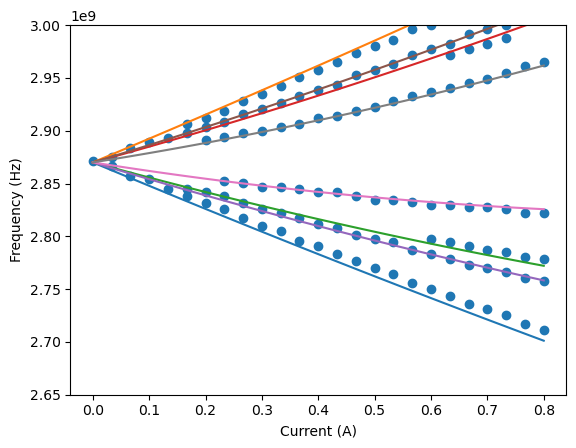

In [116]:
for i in range(1):
    random_offset = np.random.rand(3)
    coil_constant = 0.01  # in T/A originally 0.012 -> I got 0.01 for my orientation
    u = list(np.array([1.0,.2,0.25]))

    u = np.array(u)
    u = u / np.linalg.norm(u)

    current = np.linspace(0, 0.8, num=50)
    frequency = np.linspace(2.65e9, 3e9, 12)
    B0 = coil_constant * current
    B = {key: np.dot(u, e[key]) for key in e}

    diff_eigs = []
    for b0 in B0:
        H=np.ndarray((4, 3, 3), dtype=complex)
        for i in range(0, 4):
            H[i] = D * np.linalg.matrix_power(sum([NV_comp[key][i] * S[key] for key in e]), 2) + \
                g_e * b0 * sum([B[key] * S[key] for key in e])
        eigs = [np.linalg.eig(H[i])[0] for i in range(0, 4)]
        eigs = [np.sort(ev) for ev in eigs]
        diff_eigs.append([[np.real(ev[1]-ev[0]), np.real(ev[2]-ev[0])] for ev in eigs])
    diff_eigs = np.array(diff_eigs)

    fig, ax = plt.subplots()
    data = {}
    

    for i in range(0,4):
        for j in range(0,2):
            ax.plot(current, diff_eigs[:, i, j]);
    ax.set_ylim([2.65e9, 3e9]);
    ax.set_xlabel('Current (A)');
    ax.set_ylabel('Frequency (Hz)');

    ax.scatter(xs, ys)

We now wish to add the data you have measured, to the plot above to check whether it agrees with the experiment. Write a code segment below once the ODMR magnetometry experiment has been completed and you wish to use the data just measured. Note that if you want to use a previous data set, simply modify this line to grab data from the respective experiment index.